In [ ]:
import os

import polars as pl
import pyref.fitting as fit

CPU_COUNT = os.cpu_count()

# Load the Data Files


Dataset loaded from ../fitting/reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

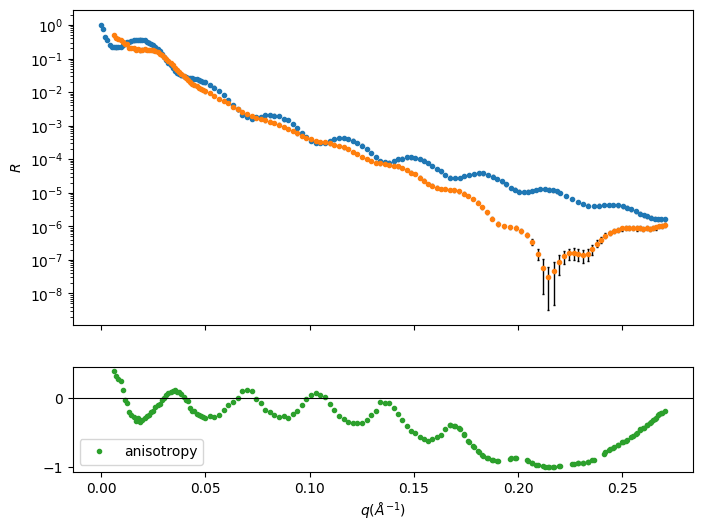

In [ ]:
def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
loaded_data = load_reflectivity_dataset("../fitting/reflectivity_data.parquet")
loaded_data["283.7"].plot(label="283.7 eV data")

In [ ]:
import pickle

with open("../fitting/fitting_results_fixed.pkl", "rb") as f:
    dft_constrained = pickle.load(f)
with open("../fitting/fitting_results_free_model.pkl", "rb") as f:
    exp_constrained = pickle.load(f)

In [ ]:
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from helper import reduced_chi2

plt.rcParams.update(
    {
        "font.size": 10,
        "figure.dpi": 300,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "xtick.top": True,
        "ytick.right": True,
    }
)


def rxr(x, model, pol):
    _pol = model.pol
    model.pol = pol
    y = model(x)
    model.pol = _pol
    return y


def anisotropy(x, model):
    r_s = rxr(x, model, "s")
    r_p = rxr(x, model, "p")
    return (r_p - r_s) / (r_p + r_s)


def plot_fit_results(
    objective,
    save_path: Path | str | None = None,
    comparitive_objective=None,
    comparitive_label=None,
):
    """
    Generates a plot of the reflectivity data comparison for s and p polarizations,
    along with the anisotropy and residuals.

    Parameters
    ----------
    objective : refell.Objective
        The objective to plot.
    save_path : str, optional
        The path to save the figure to. If None, the figure is shown.
    comparitive_objective : refell.Objective, optional
        A second objective to plot for comparison.
    """
    data = objective.data
    data.name = ""
    mod = objective.model
    #  Generate a plot of the reflectivity data comparison for the s and p polarizations
    # along with the anisotropy, and a residuals plot
    fig, ((ax_ref, ax_ani), (ax_res, ax_ani_res)) = plt.subplots(
        2, 2, figsize=(10, 3), sharex=True, gridspec_kw={"height_ratios": [3, 1]}
    )
    #  plot the data
    data.plot(ax=ax_ref, show_anisotropy=False)
    ax_ani.scatter(
        data.anisotropy.x,
        data.anisotropy.y,
        label="Data Anisotropy",
        color="C2",
        marker="o",
        s=10,
    )
    ax_ref.plot(
        data.s.x,
        rxr(data.s.x, mod, "s"),
        label="Fit (s-pol)",
        color="C0",
        linestyle="-",
    )
    #  Plot the models
    ax_ref.plot(
        data.p.x,
        rxr(data.p.x, mod, "p"),
        label="Fit (p-pol)",
        color="C1",
        linestyle="-",
    )
    ax_ani.plot(
        data.anisotropy.x,
        anisotropy(data.anisotropy.x, mod),
        label="Fit Anisotropy",
        color="C2",
        linestyle="-",
    )

    if comparitive_objective:
        mod2 = comparitive_objective.model
        ax_ref.plot(
            data.s.x,
            rxr(data.s.x, mod2, "s"),
            label="Fit2 (s-pol)",
            color="C0",
            linestyle="--",
        )
        ax_ref.plot(
            data.p.x,
            rxr(data.p.x, mod2, "p"),
            label="Fit2 (p-pol)",
            color="C1",
            linestyle="--",
        )
        ax_ani.plot(
            data.anisotropy.x,
            anisotropy(data.anisotropy.x, mod2),
            label="Fit2 Anisotropy",
            color="C2",
            linestyle="--",
        )

    ymin = ax_ref.get_ylim()[0]
    # shade below the background with a hatched area
    ax_ref.fill_between(
        x=data.s.x,
        y1=ymin,
        y2=mod.bkg.value,
        color="none",
        alpha=0.3,
        hatch="//",
        edgecolor="gray",
    )
    ax_ref.set_ylim(ymin, None)
    #  Plot the residuals
    res_s = (data.s.y - rxr(data.s.x, mod, "s")) / data.s.y_err
    res_s_quant = np.quantile(res_s, [0.1, 0.25, 0.5, 0.75, 0.9])
    res_p = (data.p.y - rxr(data.p.x, mod, "p")) / data.p.y_err
    res_p_quant = np.quantile(res_p, [0.1, 0.25, 0.5, 0.75, 0.9])
    res_a = data.anisotropy.y - anisotropy(data.anisotropy.x, mod)
    res_a_quant = np.quantile(res_a, [0.1, 0.25, 0.5, 0.75, 0.9])
    ax_res.plot(
        data.s.x,
        res_s,
        color="C0",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C0",
    )
    ax_res.fill_between(
        x=data.s.x,
        y1=res_s_quant[1],
        y2=res_s_quant[-2],
        color="C0",
        alpha=0.1,
    )
    ax_res.plot(
        data.p.x,
        res_p,
        color="C1",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C1",
    )
    ax_res.fill_between(
        x=data.p.x,
        y1=res_p_quant[1],
        y2=res_p_quant[-2],
        color="C1",
        alpha=0.1,
    )
    ax_res.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )
    ax_res.set_ylabel("Res.")
    ax_ani_res.plot(
        data.anisotropy.x,
        res_a,
        color="C2",
        linestyle="-",
        marker="o",
        markersize=2,
        lw=0.5,
        markerfacecolor="white",
        markeredgecolor="C2",
    )
    ax_ani_res.fill_between(
        x=data.anisotropy.x,
        y1=res_a_quant[1],
        y2=res_a_quant[-2],
        color="C2",
        alpha=0.1,
    )
    ax_ani_res.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )

    if comparitive_objective:
        mod2 = comparitive_objective.model
        ax_res.plot(
            data.s.x,
            (data.s.y - rxr(data.s.x, mod2, "s")) / data.s.y_err,
            color="C0",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )
        ax_res.plot(
            data.p.x,
            (data.p.y - rxr(data.p.x, mod2, "p")) / data.p.y_err,
            color="C1",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )
        ax_ani_res.plot(
            data.anisotropy.x,
            (data.anisotropy.y - anisotropy(data.anisotropy.x, mod2)),
            color="C2",
            linestyle=":",
            marker="s",
            markersize=2,
            lw=0.5,
        )

    ax_res.set_ylim(res_s_quant[0], res_s_quant[-1])
    ax_ani_res.set_ylim(res_a_quant[0], res_a_quant[-1])

    ax_ani_res.set_ylabel("Res.")
    ax_ref.set_xlim(data.anisotropy.x.min(), data.anisotropy.x.max())
    ax_ref.set_yscale("log")
    ax_ref.set_ylabel("Reflectivity [abs.]")
    ax_res.set_xlabel(r"$Q$ [$\AA^{-1}$]")
    ax_ref.legend(ncols=2, handlelength=0.5)
    ax_res.set_ylim()
    ax_ani.set_ylabel("Anisotropy [abs.]")
    ax_ani_res.set_xlabel(r"$Q$ [$\AA^{-1}$]")
    ax_ani.legend(ncols=2, handlelength=0.5)
    ax_ani.set_xlim(ax_ref.get_xlim())
    ax_ani.set_ylim(-1, 1)
    ax_ani.axhline(
        0,
        color="k",
        linestyle="-",
        lw=plt.rcParams["axes.linewidth"],
    )
    #  annotate the model.scale_s, model.scale_p, model.theta_offset_s, model.theta_offset_p
    scales = (mod.scale_s.value, mod.scale_p.value)
    offsets = (mod.theta_offset_s.value, mod.theta_offset_p.value)
    text = (
        f"Scale (s, p): ({scales[0]:.2f}, {scales[1]:.2f})\n"
        f"Offset (s, p): ({offsets[0]:.2f}, {offsets[1]:.2f})\n"
        f"Background : {mod.bkg.value:.1e}"
    )
    if comparitive_objective:
        mod2 = comparitive_objective.model
        scales2 = (mod2.scale_s.value, mod2.scale_p.value)
        offsets2 = (mod2.theta_offset_s.value, mod2.theta_offset_p.value)
        text = (
            f"Scale (s, p): ({scales[0]:.2f}, {scales[1]:.2f}) | ({scales2[0]:.2f}, {scales2[1]:.2f})\n"
            f"Offset (s, p): ({offsets[0]:.2f}, {offsets[1]:.2f}) | ({offsets2[0]:.2f}, {offsets2[1]:.2f})\n"
            f"Background : {mod.bkg.value:.1e} | {mod2.bkg.value:.1e}"
        )

    ax_ref.text(
        0.05,
        0.3,
        s=text,
        transform=ax_ref.transAxes,
        va="top",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7),
    )
    fig.align_ylabels()
    fig.suptitle(
        rf"Fit at {mod.energy} eV $\chi^2_{{red}} = {reduced_chi2(objective):.2f}$"
        + (f" | {comparitive_label} in dashed" if comparitive_label else "")
    )

    if save_path:
        fig.savefig(save_path, dpi=300)
        plt.close(fig)
    else:
        plt.show()


def export_fit_results(
    objectives,
    save_folder: Path = Path("figures"),
    comparitive_objectives=None,
    comparitive_label=None,
):
    """
    Export comparison plots for a list of objectives.

    Parameters
    ----------
    objectives : list of refell.Objective
        The objectives to plot.
    folder : str, optional
        The folder to save the figures to. Default is "figures".
    """

    #  add current year_month_day to the folder name
    folder = save_folder / datetime.now().strftime("%Y%m%d")
    if not os.path.exists(folder):
        os.makedirs(folder)
    for obj in objectives:
        comp_obj = (
            next(
                (
                    co
                    for co in comparitive_objectives
                    if co.model.energy == obj.model.energy
                ),
                None,
            )
            if comparitive_objectives
            else None
        )
        energy = obj.model.energy
        save_path = os.path.join(folder, f"fit_comparison_{energy}eV.png")
        plot_fit_results(
            obj,
            save_path=save_path,
            comparitive_objective=comp_obj,
            comparitive_label=comparitive_label,
        )


export_fit_results(
    dft_constrained.objectives, save_folder=Path("figures/dft_constrained")
)
export_fit_results(
    exp_constrained.objectives, save_folder=Path("figures/exp_constrained")
)
export_fit_results(
    dft_constrained.objectives,
    save_folder=Path("figures/comparative"),
    comparitive_objectives=exp_constrained.objectives,
    comparitive_label="Free Model Fit",
)

/home/hduva/projects/xrr_notebooks/.venv/lib/python3.12/site-packages/pyref/fitting/io.py:190: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


In [31]:
from matplotlib.lines import Line2D


def export_two_energy_comparison(
    exp_constrained, dft_constrained, loaded_data, output_dir: Path | None = None
):
    """
    Export a comparison plot between experimental and DFT-constrained fits
    at two selected energies.

    Parameters
    ----------
    exp_constrained : refell.FittingResults
        Fitting results with experimental constraints.
    dft_constrained : refell.FittingResults
        Fitting results with DFT constraints.
    loaded_data : dict
        Dictionary containing XrayReflectDataset objects with energy keys.
    """

    # Define the two energies for comparison
    comparison_energies = np.array([250.0, 283.7])

    # Extract the relevant objectives and data for the selected energies
    exp_objectives = {obj.model.energy: obj for obj in exp_constrained.objectives}
    dft_objectives = {obj.model.energy: obj for obj in dft_constrained.objectives}

    cols = ["C0", "C1"]

    fig, (ax, ax_depth1, ax_depth2) = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(8.5, 2),
        constrained_layout=True,
        gridspec_kw={"width_ratios": [3, 1, 1]},
    )

    for i, (E, col) in enumerate(zip(comparison_energies, cols)):
        # ----- Get objects for the current energy -----
        o_exp = exp_objectives[E]
        o_dft = dft_objectives[E]
        data = loaded_data[str(E)]
        scale = 50 ** (-2 * i)  # Vertical offset for clarity
        bkg = data.p.y.min()  # Estimate background from data

        # ----- Helper to prevent log(0) errors -----
        def _clip_low(arr):
            return np.clip(arr, 1e-12, None)

        # ----- Plot Data points with ±2σ error bands -----
        for pol, marker_style in [("s", "o"), ("p", "s")]:
            pol_data = getattr(data, pol)
            ax.fill_between(
                pol_data.x,
                _clip_low((pol_data.y - 2 * pol_data.y_err) * scale),
                (pol_data.y + 2 * pol_data.y_err) * scale,
                color=col,
                alpha=0.15,
            )
            ax.plot(
                pol_data.x,
                pol_data.y * scale,
                color=col,
                lw=2.2,
                marker=marker_style,
                markevery=10,
                markerfacecolor="none",
                markeredgecolor=col,
                markeredgewidth=1.0,
                label="_nolegend_",
            )

        for pol in ["s", "p"]:
            pol_data = getattr(data, pol)
            # Experimental model fit (solid line)
            y_exp = rxr(pol_data.x, o_exp.model, pol)
            ax.plot(pol_data.x, y_exp * scale, color="k", lw=1.5, zorder=10)

            # DFT model fit (dashed line)
            y_dft = rxr(pol_data.x, o_dft.model, pol)
            ax.plot(pol_data.x, y_dft * scale, color="k", lw=1.2, ls="--", zorder=10)

            # Optional: Shade the difference between the two models
            ax.fill_between(
                pol_data.x,
                np.minimum(y_exp, y_dft) * scale,
                np.maximum(y_exp, y_dft) * scale,
                color=col,
                alpha=0.12,
                zorder=5,
            )
    model1 = o_exp.model
    model2 = o_dft.model
    # Plot the depth profiles
    model1.structure.plot(ax=ax_depth1)
    model2.structure.plot(ax=ax_depth2)

    ax_depth1.set_xlabel("Depth (Å)")
    ax_depth1.set_ylabel("Optical Constants (a.u.)")
    ax_depth2.set_xlabel("Depth (Å)")
    ax_depth2.set_ylabel("Optical Constants (a.u.)")
    #  Ensure the legends have 2 columns
    ax_depth1.get_legend()._ncols = 2
    ax_depth2.get_legend()._ncols = 2

    ax.set_xlim(0, 0.27)
    ax.set_yscale("log")
    ax.set_xlabel(r"$Q\ (\AA^{-1})$")
    ax.set_ylabel(r"Reflectivity (a.u.)")
    ax.minorticks_on()

    style_legend_handles = [
        Line2D(
            [],
            [],
            marker="o",
            color="k",
            mfc="none",
            ms=6,
            ls="None",
            label=r"$s$-pol data",
        ),
        Line2D(
            [],
            [],
            marker="s",
            color="k",
            mfc="none",
            ms=6,
            ls="None",
            label=r"$p$-pol data",
        ),
        Line2D([], [], color="k", lw=1.5, ls="-", label=r"Model fit"),
        Line2D([], [], color="k", lw=1.2, ls="--", label=r"DFT fit"),
    ]
    leg1 = ax.legend(
        handles=style_legend_handles,
        loc="upper right",
        fontsize="small",
        title_fontsize="small",
        ncols=2,
        handlelength=0.5,
    )
    ax.add_artist(leg1)

    energy_legend_handles = [Line2D([], [], color=c, lw=2.5) for c in cols]
    energy_labels = [f"{E:.1f} eV" for E in comparison_energies]
    ax.legend(
        handles=energy_legend_handles,
        labels=energy_labels,
        title="Photon energy",
        loc="lower left",
        fontsize="small",
        title_fontsize="small",
        ncols=2,
        handlelength=0.5,
    )
    if output_dir:
        output_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(
            output_dir
            / f"{datetime.now().strftime('%Y%m%d')}_{comparison_energies[0]}_{comparison_energies[1]}.png",
            dpi=300,
        )
        plt.close(fig)
    else:
        plt.show()


export_two_energy_comparison(
    exp_constrained, dft_constrained, loaded_data, output_dir=Path("figures")
)

In [ ]:
import matplotlib.ticker as ticker
from helper import aic, bic


# ------------------------------------------------------------
#  Helper: draw the diagonal break symbols
# ------------------------------------------------------------
def _add_break(ax_left, ax_right, size=5):
    """Draw diagonal break symbols on a pair of axes."""
    d = 2
    kw = dict(
        marker=[(-1, -d), (1, d)],
        markersize=size,
        linestyle="none",
        color="k",
        mec="k",
        mew=1,
        clip_on=False,
    )
    ax_left.plot([1, 1], [0, 1], transform=ax_left.transAxes, **kw)
    ax_right.plot([0, 0], [0, 1], transform=ax_right.transAxes, **kw)


# ------------------------------------------------------------
#  Main plotting routine
# ------------------------------------------------------------
def plot_stats(df_stats: pl.DataFrame, save_path: Path | str | None = None):
    """
    Plot fitting statistics in a 5-row x 2-col layout.
    Left column: 248.5 - 276.5 eV,   Right column: 279.5 - 290 eV.
    Each row shows a single metric (no twin axes).
    """
    # --------------------------------------------------------
    # 1. Split global vs. local rows and extract NumPy arrays
    # --------------------------------------------------------
    global_stats = df_stats.filter(pl.col("Energy (eV)") == 0)
    local = df_stats.filter(pl.col("Energy (eV)") != 0)

    E = local["Energy (eV)"].to_numpy()
    chi2 = local["Reduced Chi^2"].to_numpy()
    bic = local["BIC"].to_numpy()
    aic = local["AIC"].to_numpy()
    npar = local["Number of Parameters"].to_numpy()
    ndata = local["Number of Data Points"].to_numpy()

    # --------------------------------------------------------
    # 2. Define the metrics to plot
    # --------------------------------------------------------
    metrics = [
        ("Reduced chi2", chi2, "C0", r"$\chi^2_{\rm red}$"),
        ("BIC", bic, "C1", "BIC"),
        ("AIC", aic, "C2", "AIC"),
        ("# Params", npar, "C3", "# Params"),
        ("# Data", ndata, "C4", "# Data"),
    ]

    # --------------------------------------------------------
    # 3. Figure / axes layout (5 rows, 2 columns, thin left column)
    # --------------------------------------------------------
    fig, ax = plt.subplots(
        nrows=len(metrics),
        ncols=2,
        figsize=(6, 5),
        gridspec_kw=dict(width_ratios=[1, 9], wspace=0.05, hspace=0.1),
        sharex="col",
    )
    fig.subplots_adjust(bottom=0.08)  # space for the shared x‑label

    # --------------------------------------------------------
    # 4. Energy split masks (left vs. right panel)
    # --------------------------------------------------------
    split_val = 277.0
    left_mask = E <= split_val
    right_mask = E > split_val

    # --------------------------------------------------------
    # 5. Plot each metric
    # --------------------------------------------------------
    for i, (title, y, col, ylabel) in enumerate(metrics):
        # left panel
        ax[i, 0].plot(
            E[left_mask],
            y[left_mask],
            "o",
            markersize=2,
            markerfacecolor="white",
            color=col,
            lw=0.5,
        )
        # right panel
        ax[i, 1].plot(
            E[right_mask],
            y[right_mask],
            "o",
            markersize=2,
            markerfacecolor="white",
            color=col,
            lw=0.5,
        )

        # y‑label on the left side only
        ax[i, 0].set_ylabel(ylabel, color=col)
        # ax[i, 0].tick_params(axis="y", colors=col)

        # annotate global values on the right panel (if present)
        if not global_stats.is_empty() and title in global_stats.columns:
            gval = global_stats[title][0]
            txt = (
                f"Global {title} = {gval:.2f}"
                if isinstance(gval, float)
                else f"Global {title} = {gval}"
            )
            ax[i, 1].annotate(
                txt,
                xy=(0.05, 0.5),
                xycoords="axes fraction",
                ha="left",
                fontsize=8,
                bbox=dict(
                    boxstyle="round", alpha=0.1, edgecolor="k", facecolor="white"
                ),
            )

        # break symbols
        _add_break(ax[i, 0], ax[i, 1])

        # ----------------------------------------------------
        # hide inner spines and their ticks (the “break” region)
        # ----------------------------------------------------
        ax[i, 0].spines["right"].set_visible(False)
        ax[i, 0].yaxis.set_ticks_position("left")
        ax[i, 1].spines["left"].set_visible(False)
        ax[i, 1].yaxis.set_ticks_position("right")
        # # optional: hide top spines for a cleaner look
        # ax[i, 0].spines["top"].set_visible(False)
        # ax[i, 1].spines["top"].set_visible(False)

    # --------------------------------------------------------
    # 6. Axis limits & tick formatting
    # --------------------------------------------------------
    left_xlim = (248.5, 276.5)
    right_xlim = (279.5, 290.0)

    for a in ax[:, 0].flatten():
        a.set_xlim(*left_xlim)
    for a in ax[:, 1].flatten():
        a.set_xlim(*right_xlim)
        a.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # show x‑ticks only on the bottom row
    ax[-1, 0].tick_params(bottom=True, labelbottom=True)
    ax[-1, 1].tick_params(bottom=True, labelbottom=True)

    # --------------------------------------------------------
    # 7. Figure‑wide labels & layout
    # --------------------------------------------------------
    fig.supxlabel("Energy (eV)", y=0.02)
    fig.align_ylabels()
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # keep space for supxlabel

    # --------------------------------------------------------
    # 8. Save or display
    # --------------------------------------------------------
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()


def export_stats(objectives, save_path: Path):
    """
    Export fitting statistics for a list of objectives to a CSV file.

    Parameters
    ----------
    objectives : list of refell.Objective
        The objectives to analyze.
    save_path : str, optional
        The path to save the CSV file to. Default is "fitting_stats.csv".
    """
    #  append the date_time to the save_path name
    save_path = save_path.with_name(
        f"{save_path.stem}_{datetime.now().strftime('%Y%m%d')}.csv"
    )
    #  Make the parent directory if it doesn't exist
    save_path.parent.mkdir(parents=True, exist_ok=True)
    stats = []
    for obj in objectives:
        energy = obj.model.energy
        chi2_red = reduced_chi2(obj)
        n_params = len(obj.varying_parameters())
        n_data = len(obj.data.s.x) + len(obj.data.p.x)
        stats.append(
            {
                "Energy (eV)": energy,
                "Reduced Chi^2": chi2_red,
                "Number of Parameters": n_params,
                "Number of Data Points": n_data,
                "AIC": aic(obj),
                "BIC": bic(obj),
            }
        )
    #  Use a global objective to save the total stats
    _glob = fit.GlobalObjective(objectives)
    global_stats = {
        "Energy (eV)": 0,
        "Reduced Chi^2": reduced_chi2(_glob),
        "Number of Parameters": len(_glob.varying_parameters()),
        "Number of Data Points": sum(
            len(obj.data.s.x) + len(obj.data.p.x) for obj in objectives
        ),
        "AIC": aic(_glob),
        "BIC": bic(_glob),
    }
    stats.append(global_stats)
    df_stats = pl.DataFrame(stats)
    #  Sort by Energy
    df_stats = df_stats.sort("Energy (eV)")
    df_stats.write_csv(save_path)
    #  Also plot the stats
    plot_stats(df_stats, save_path=save_path.with_suffix(".png"))


export_stats(
    dft_constrained.objectives,
    save_path=Path("figures/fitting_stats_dft_constrained.csv"),
)
export_stats(
    exp_constrained.objectives,
    save_path=Path("figures/fitting_stats_exp_constrained.csv"),
)

/tmp/ipykernel_311366/2147445160.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.96])  # keep space for supxlabel
